In [336]:
from pyspark.sql import SparkSession
import pyspark.sql.functions as f
import numpy as np

In [337]:
import matplotlib.pyplot as plt
import seaborn as sns

In [338]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

In [339]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

In [340]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

In [341]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

In [342]:
from IPython.display import display, HTML

In [343]:
spark = SparkSession.builder.master('local').appName('BreastCancer').config('spark.executor.memory','6gb').getOrCreate()

In [344]:
url = 'C:/Users/Dylan/Desktop/Datasets/result-breast-cancer.csv'
df = spark.read.format('com.databricks.spark.csv').options(header='True', inferschema='True').load(url)
df.show(10)

+---+-----+---------+----------+---------+---------+---------+------+-----------+--------+--------------------+
| id|  age|menopause|tumor-size|inv-nodes|node-caps|deg-malig|breast|breast-quad|irradiat|               Class|
+---+-----+---------+----------+---------+---------+---------+------+-----------+--------+--------------------+
|  1|40-49|  premeno|     25-29|    24-26|      yes|        3| right|    central|      no|   recurrence-events|
|  2|40-49|  premeno|     25-29|      0-2|       no|        2|  left|   left_low|      no|no-recurrence-events|
|  3|60-69|     lt40|     25-29|      0-2|       no|        2| right|   left_low|      no|no-recurrence-events|
|  4|40-49|     ge40|     10-14|      0-2|       no|        3|  left|   left_low|      no|no-recurrence-events|
|  5|40-49|  premeno|       5-9|      0-2|       no|        1| right|    central|      no|no-recurrence-events|
|  6|50-59|     ge40|     20-24|      0-2|       no|        2| right|   left_low|      no|no-recurrence-

In [345]:
df = df.toPandas()
df.head()

,id,age,menopause,tumor-size,inv-nodes,node-caps,deg-malig,breast,breast-quad,irradiat,Class
0,1,40-49,premeno,25-29,24-26,yes,3,right,central,no,recurrence-events
1,2,40-49,premeno,25-29,0-2,no,2,left,left_low,no,no-recurrence-events
2,3,60-69,lt40,25-29,0-2,no,2,right,left_low,no,no-recurrence-events
3,4,40-49,ge40,10-14,0-2,no,3,left,left_low,no,no-recurrence-events
4,5,40-49,premeno,5-9,0-2,no,1,right,central,no,no-recurrence-events


In [346]:
df = df.drop(['id'], axis=1)
df.head()

,age,menopause,tumor-size,inv-nodes,node-caps,deg-malig,breast,breast-quad,irradiat,Class
0,40-49,premeno,25-29,24-26,yes,3,right,central,no,recurrence-events
1,40-49,premeno,25-29,0-2,no,2,left,left_low,no,no-recurrence-events
2,60-69,lt40,25-29,0-2,no,2,right,left_low,no,no-recurrence-events
3,40-49,ge40,10-14,0-2,no,3,left,left_low,no,no-recurrence-events
4,40-49,premeno,5-9,0-2,no,1,right,central,no,no-recurrence-events


In [347]:
df_columns = ['age','menopause','tumor-size','inv-nodes','node-caps','deg-malig','breast','breast-quad','irradiat','Class']
for col in df_columns:
    print(col+': ')
    print(df[col].value_counts())
    print(' ')

age: 
50-59    329377
40-49    308885
60-69    196058
30-39    124910
70-79     23958
20-29      6746
80-89      3408
10-19      3374
90-99      3284
Name: age, dtype: int64
 
menopause: 
premeno    513368
ge40       443036
lt40        43596
Name: menopause, dtype: int64
 
tumor-size: 
30-34    204140
25-29    183570
20-24    171599
15-19    104554
10-14     98145
40-44     77056
35-39     66980
0-4       30340
50-54     30045
5-9       16867
45-49     13459
55-59      3245
Name: tumor-size, dtype: int64
 
inv-nodes: 
0-2      717981
3-5      122713
6-8       59665
9-11      36606
15-17     23138
12-14     13385
24-26      6479
21-23      3416
27-29      3374
33-35      3354
18-20      3343
36-39      3300
30-32      3246
Name: inv-nodes, dtype: int64
 
node-caps: 
no     793878
yes    206122
Name: node-caps, dtype: int64
 
deg-malig: 
2    453534
3    296720
1    249746
Name: deg-malig, dtype: int64
 
breast: 
left     530800
right    469200
Name: breast, dtype: int64
 
breast-quad: 


In [348]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 10 columns):
 #   Column       Non-Null Count    Dtype 
---  ------       --------------    ----- 
 0   age          1000000 non-null  object
 1   menopause    1000000 non-null  object
 2   tumor-size   1000000 non-null  object
 3   inv-nodes    1000000 non-null  object
 4   node-caps    1000000 non-null  object
 5   deg-malig    1000000 non-null  int32 
 6   breast       1000000 non-null  object
 7   breast-quad  1000000 non-null  object
 8   irradiat     1000000 non-null  object
 9   Class        1000000 non-null  object
dtypes: int32(1), object(9)
memory usage: 72.5+ MB


In [349]:
df.describe()

,deg-malig
count,1000000.000000
mean,2.046974
std,0.737740
min,1.000000
25%,2.000000
50%,2.000000
75%,3.000000
max,3.000000


In [350]:
df.shape

(1000000, 10)

age            0
menopause      0
tumor-size     0
inv-nodes      0
node-caps      0
deg-malig      0
breast         0
breast-quad    0
irradiat       0
Class          0
dtype: int64

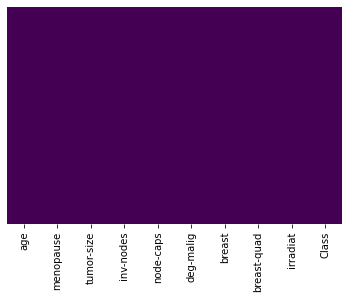

In [351]:
sns.heatmap(df.isnull(), yticklabels=False, cbar=False, cmap='viridis')
df.isnull().sum()

no-recurrence-events    702823
recurrence-events       297177
Name: Class, dtype: int64

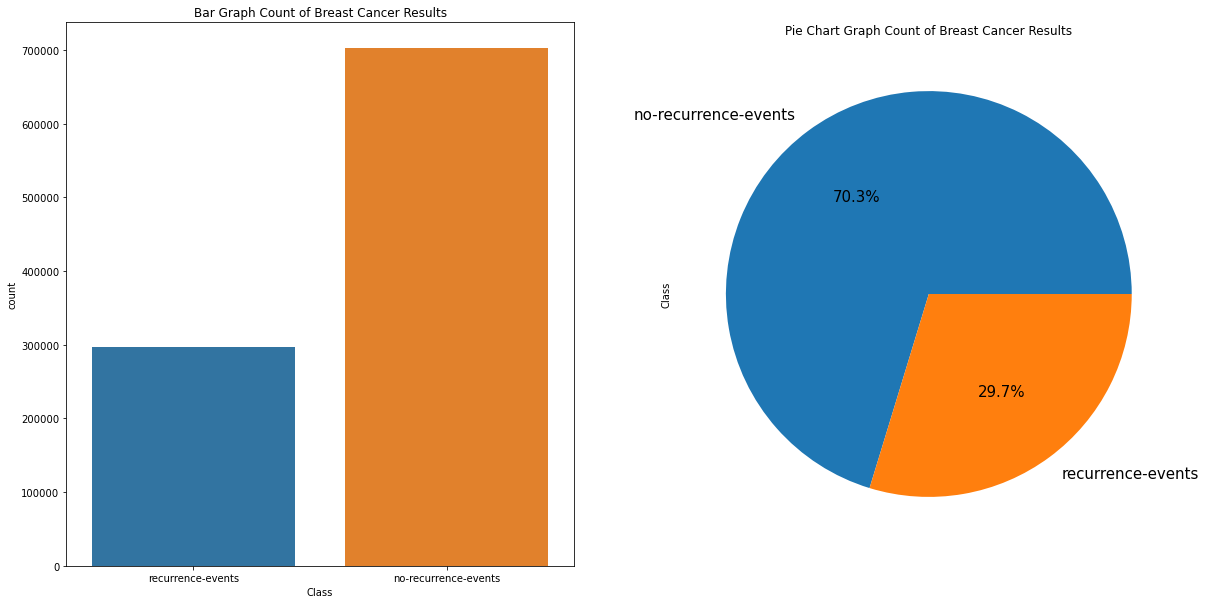

In [352]:
df['Class'].value_counts()
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,10))
ax1.set_title('Bar Graph Count of Breast Cancer Results')
ax2.set_title('Pie Chart Graph Count of Breast Cancer Results')
sns.countplot(x=df['Class'], ax=ax1)
df['Class'].value_counts().plot.pie(autopct='%1.1f%%',shadow=False,textprops={'fontsize': 15},ax=ax2) 
df['Class'].value_counts()

In [353]:
df.columns

Index(['age', 'menopause', 'tumor-size', 'inv-nodes', 'node-caps', 'deg-malig',
       'breast', 'breast-quad', 'irradiat', 'Class'],
      dtype='object')

In [354]:
Categorical_features = ['age', 'menopause', 'tumor-size', 'inv-nodes', 'node-caps','breast', 'breast-quad', 'irradiat']
Numerical_features = ['deg-malig']
target = ['Class']

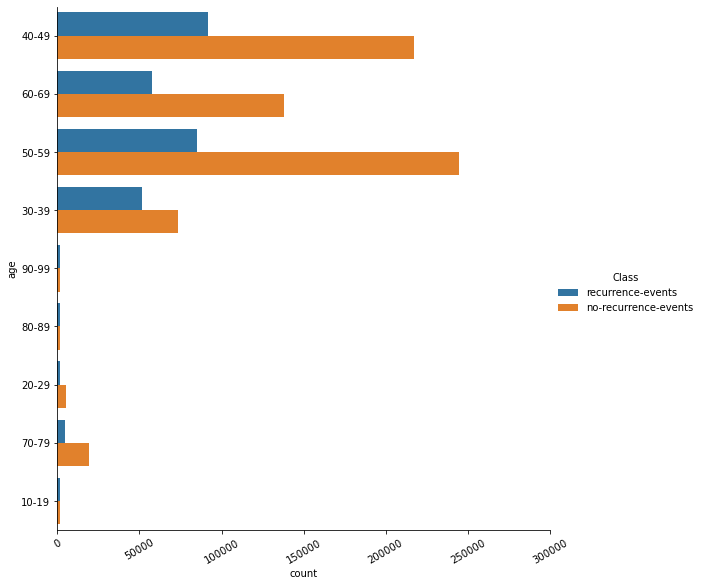

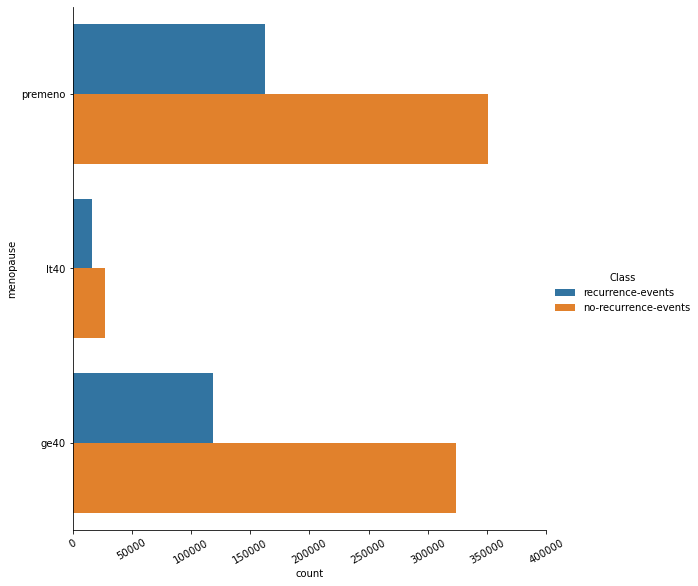

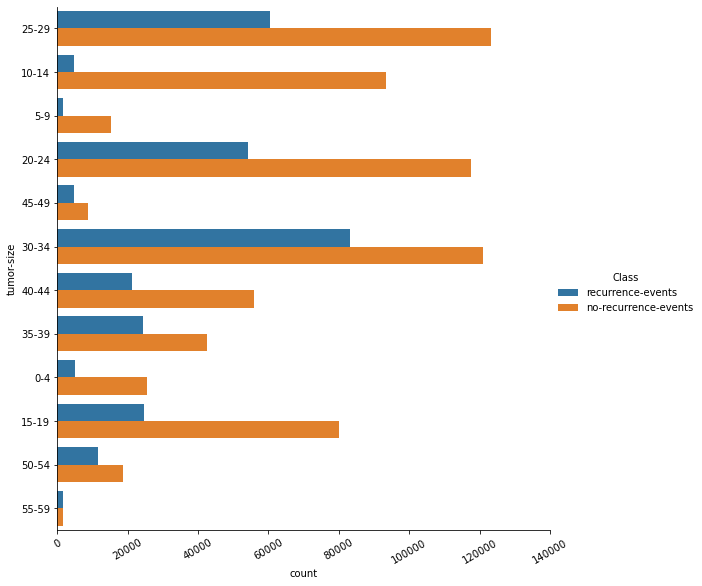

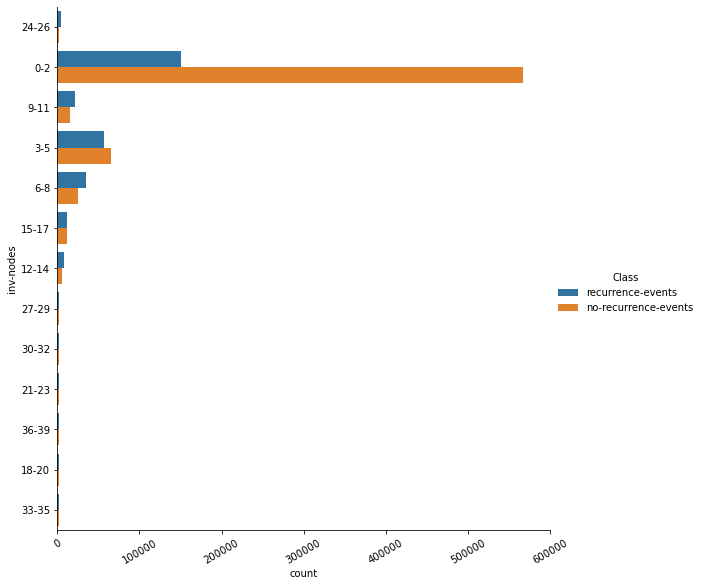

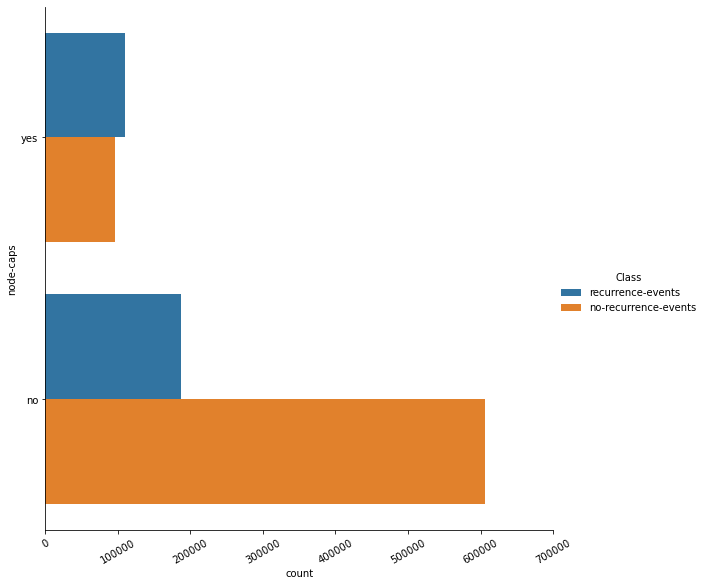

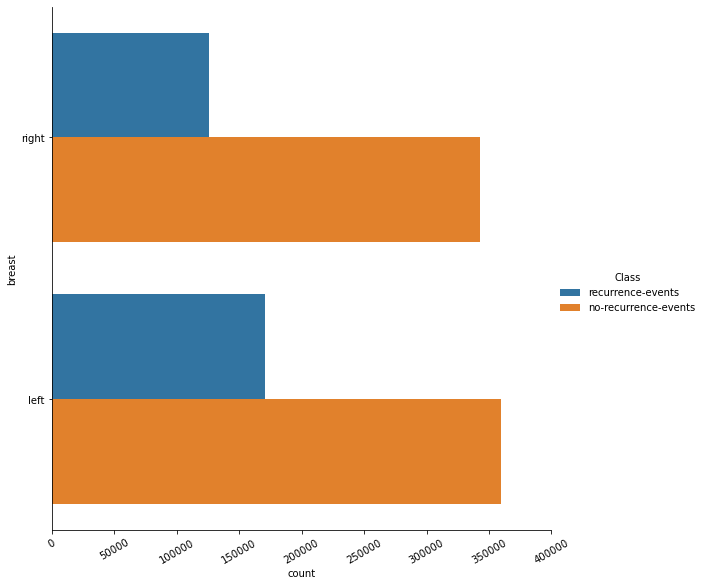

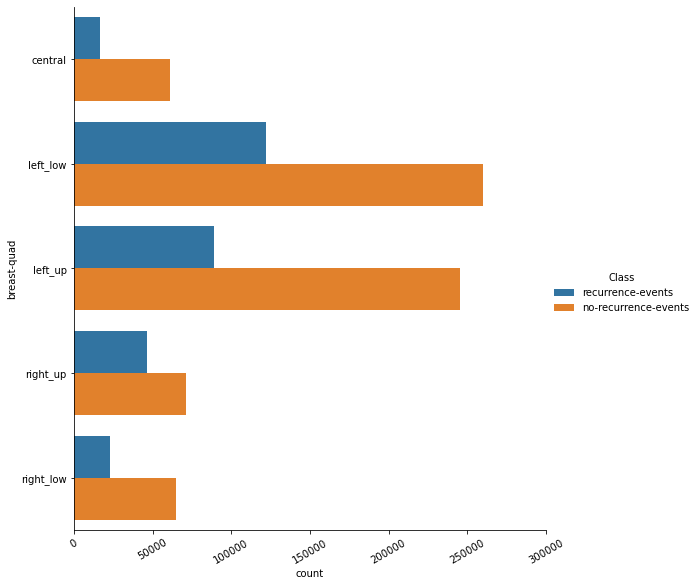

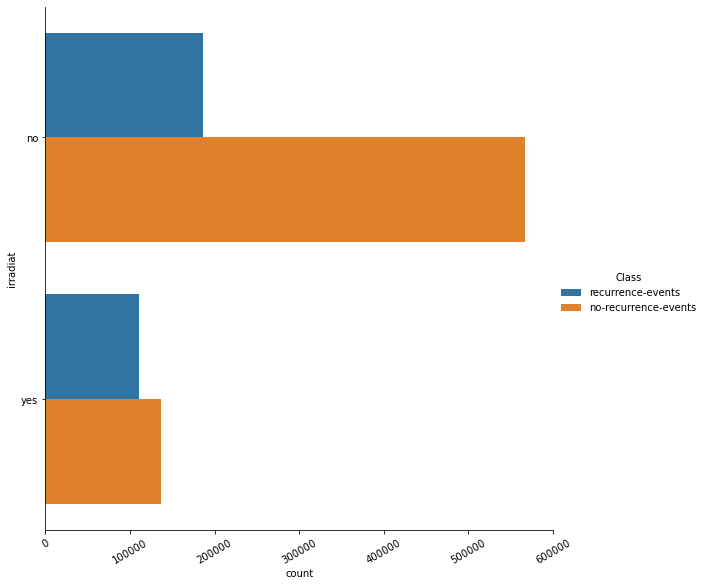

In [355]:
for col in Categorical_features:
    fig = sns.catplot(data=df, y=col, hue='Class', kind='count', orient='V', height=8)
    fig.set_xticklabels(rotation=30)
    plt.show()

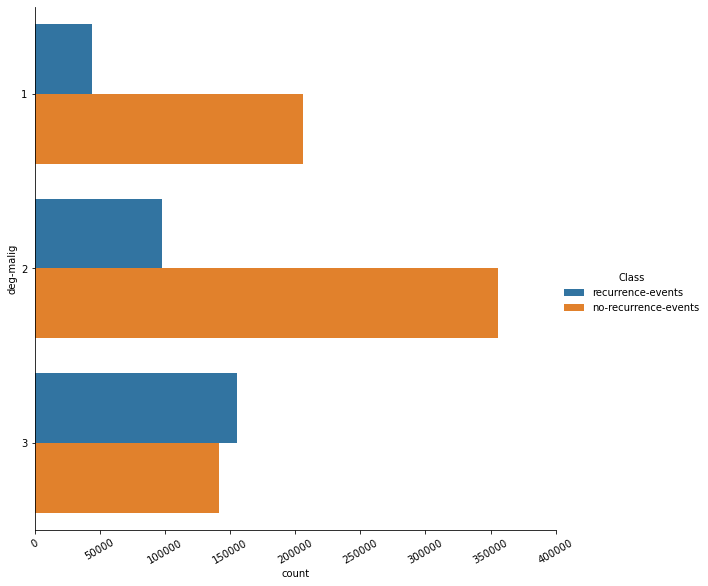

In [356]:
fig = sns.catplot(data=df, y='deg-malig', hue='Class', kind='count', orient='V', height=8)
fig.set_xticklabels(rotation=30)
plt.show()

In [357]:
Categorical_features = ['age', 'menopause', 'tumor-size', 'inv-nodes', 'node-caps','breast', 'breast-quad', 'irradiat','Class']
for x in Categorical_features:
    df[x] = LabelEncoder().fit_transform(df[x])

In [358]:
df.head()

,age,menopause,tumor-size,inv-nodes,node-caps,deg-malig,breast,breast-quad,irradiat,Class
0,3,2,4,5,1,3,1,0,0,1
1,3,2,4,0,0,2,0,1,0,0
2,5,1,4,0,0,2,1,1,0,0
3,3,0,1,0,0,3,0,1,0,0
4,3,2,9,0,0,1,1,0,0,0


In [359]:
df.describe()

,age,menopause,tumor-size,inv-nodes,node-caps,deg-malig,breast,breast-quad,irradiat,Class
count,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000
mean,3.674895,1.070332,4.113922,2.179725,0.206122,2.046974,0.469200,1.787228,0.247554,0.297177
std,1.092079,0.975427,2.233561,3.877630,0.404519,0.737740,0.499051,1.098555,0.431591,0.457015
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,3.000000,0.000000,3.000000,0.000000,0.000000,2.000000,0.000000,1.000000,0.000000,0.000000
50%,4.000000,2.000000,4.000000,0.000000,0.000000,2.000000,0.000000,2.000000,0.000000,0.000000
75%,4.000000,2.000000,5.000000,2.000000,0.000000,3.000000,1.000000,2.000000,0.000000,1.000000
max,8.000000,2.000000,11.000000,12.000000,1.000000,3.000000,1.000000,4.000000,1.000000,1.000000


In [360]:
df.corr()

,age,menopause,tumor-size,inv-nodes,node-caps,deg-malig,breast,breast-quad,irradiat,Class
age,1.000000,-0.620075,-0.007442,-0.018245,-0.017067,-0.016893,0.002483,-0.002215,-0.013629,-0.060091
menopause,-0.620075,1.000000,0.006553,0.015832,0.015226,0.014009,-0.002750,0.000997,0.011186,0.050246
tumor-size,-0.007442,0.006553,1.000000,0.036830,0.034664,0.037576,-0.008544,0.004872,0.024006,0.129071
inv-nodes,-0.018245,0.015832,0.036830,1.000000,0.579048,0.209612,-0.017017,0.014317,0.357037,0.283772
node-caps,-0.017067,0.015226,0.034664,0.579048,1.000000,0.313255,-0.016379,0.013004,0.295931,0.261794
deg-malig,-0.016893,0.014009,0.037576,0.209612,0.313255,1.000000,-0.017031,0.013650,0.114991,0.288181
breast,0.002483,-0.002750,-0.008544,-0.017017,-0.016379,-0.017031,1.000000,0.200861,-0.011957,-0.057931
breast-quad,-0.002215,0.000997,0.004872,0.014317,0.013004,0.013650,0.200861,1.000000,0.009383,0.048598
irradiat,-0.013629,0.011186,0.024006,0.357037,0.295931,0.114991,-0.011957,0.009383,1.000000,0.190184
Class,-0.060091,0.050246,0.129071,0.283772,0.261794,0.288181,-0.057931,0.048598,0.190184,1.000000


<AxesSubplot:>

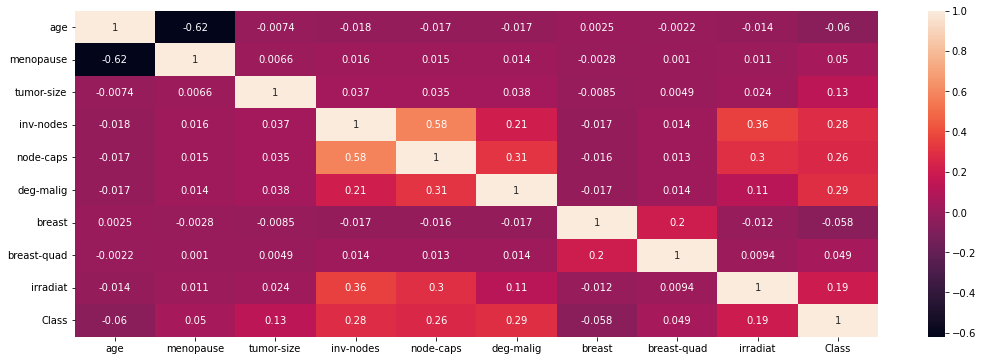

In [361]:
fig = plt.subplots(figsize=(18,6))
sns.heatmap(df.corr(),annot=True)

In [362]:
df.columns

Index(['age', 'menopause', 'tumor-size', 'inv-nodes', 'node-caps', 'deg-malig',
       'breast', 'breast-quad', 'irradiat', 'Class'],
      dtype='object')

In [363]:
# Logistic Regression
class CustomLogisticRegression() :
    def __init__( self, learning_rate, iterations ) :        
        self.learning_rate = learning_rate        
        self.iterations = iterations
          
    # Function for model training    
    def fit( self, X, Y ) :        
        # no_of_training_examples, no_of_features        
        self.m, self.n = X.shape        
        # weight initialization        
        self.W = np.zeros( self.n )        
        self.b = 0        
        self.X = X        
        self.Y = Y
          
        # gradient descent learning
                  
        for i in range( self.iterations ) :            
            self.update_weights()            
        return self
      
    # Helper function to update weights in gradient descent
      
    def update_weights( self ) :           
        A = 1 / ( 1 + np.exp( - ( self.X.dot( self.W ) + self.b ) ) )
          
        # calculate gradients        
        tmp = ( A - self.Y.T )        
        tmp = np.reshape( tmp, self.m )        
        dW = np.dot( self.X.T, tmp ) / self.m         
        db = np.sum( tmp ) / self.m 
          
        # update weights    
        self.W = self.W - self.learning_rate * dW    
        self.b = self.b - self.learning_rate * db
          
        return self
      
    # Hypothetical function  h( x ) 
      
    def predict( self, X ) :    
        Z = 1 / ( 1 + np.exp( - ( X.dot( self.W ) + self.b ) ) )        
        Y = np.where( Z > 0.5, 1, 0 )        
        return Y

In [364]:
# This function is serving as the Confusion Matrix Graph
# This will be needed for the evaluation of the graphs
# The function will take the y_test values and the prediciton value calculated in the model creation

def Confusion_Matrix_Graph(y_test,prediction):
    
    cm = confusion_matrix(y_test,prediction)
    plt.subplots(figsize=(18, 6))
    sns.heatmap(cm/np.sum(cm), annot= True, fmt='.2%', cmap='Blues')

In [365]:
# This function is serving as the ROC Curve Graph
# This will be needed for the evaluation of the graphs
# The function will take the X_test and y_test as parameters

def ROC_Curve_Graph(X_test,y_test,model):
    
    y_pred_proba = model.predict_proba(X_test)[::,1]
    fpr, tpr, _ = roc_curve(y_test,  y_pred_proba)
    auc = roc_auc_score(y_test, y_pred_proba)
    plt.subplots(figsize=(18, 6))
    plt.plot(fpr,tpr,label="Prediction, auc="+str(auc))
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.legend(loc=4)
    plt.show()

In [366]:
y = df['Class']
y.head()

0    1
1    0
2    0
3    0
4    0
Name: Class, dtype: int32

In [367]:
X = df[['age', 'menopause', 'tumor-size', 'inv-nodes', 'node-caps', 'deg-malig','breast', 'breast-quad', 'irradiat']]
X.head()

,age,menopause,tumor-size,inv-nodes,node-caps,deg-malig,breast,breast-quad,irradiat
0,3,2,4,5,1,3,1,0,0
1,3,2,4,0,0,2,0,1,0
2,5,1,4,0,0,2,1,1,0
3,3,0,1,0,0,3,0,1,0
4,3,2,9,0,0,1,1,0,0


In [368]:
X = StandardScaler().fit_transform(X)
print(X)

[[-0.61799121  0.95308845 -0.05100468 ...  1.0636199  -1.62689055
  -0.57358437]
 [-0.61799121  0.95308845 -0.05100468 ... -0.94018549 -0.71660347
  -0.57358437]
 [ 1.21337874 -0.07210382 -0.05100468 ...  1.0636199  -0.71660347
  -0.57358437]
 ...
 [-0.61799121  0.95308845 -0.05100468 ... -0.94018549  0.1936836
   1.74342269]
 [ 0.29769377 -1.09729609 -0.49872045 ...  1.0636199  -0.71660347
   1.74342269]
 [-1.53367619  0.95308845 -1.84186778 ... -0.94018549  0.1936836
  -0.57358437]]


In [369]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.5, random_state=0
    )

<AxesSubplot:xlabel='Class', ylabel='count'>

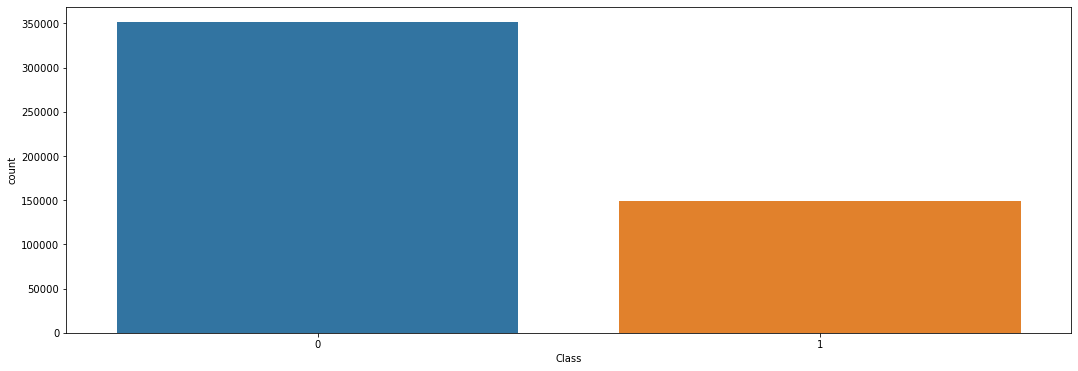

In [370]:
fig = plt.subplots(figsize=(18,6))
sns.countplot(x=y_train)

In [371]:
X_train, y_train = SMOTE(random_state=0).fit_resample(X_train,y_train)


<AxesSubplot:xlabel='Class', ylabel='count'>

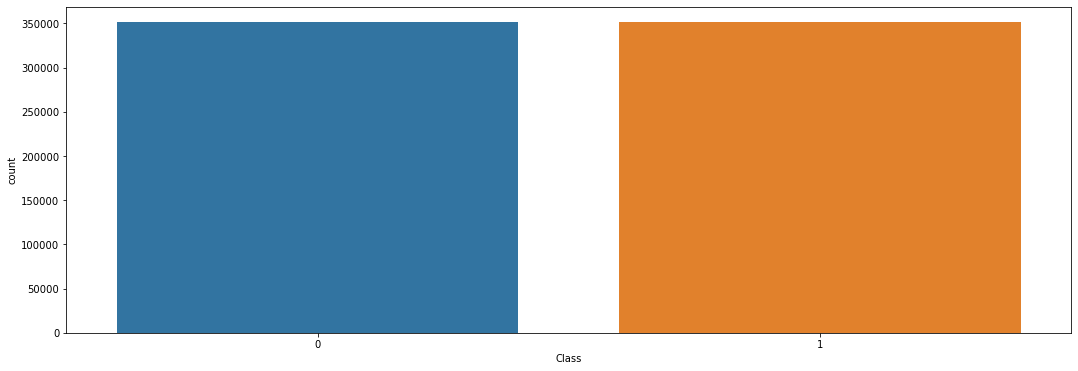

In [372]:
fig = plt.subplots(figsize=(18,6))
sns.countplot(x=y_train)

----------------------------------------------------------------
The Accuracy of the model is :  69.30279999999999 %
----------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.83      0.70      0.76    351408
           1       0.49      0.66      0.56    148592

    accuracy                           0.69    500000
   macro avg       0.66      0.68      0.66    500000
weighted avg       0.73      0.69      0.70    500000



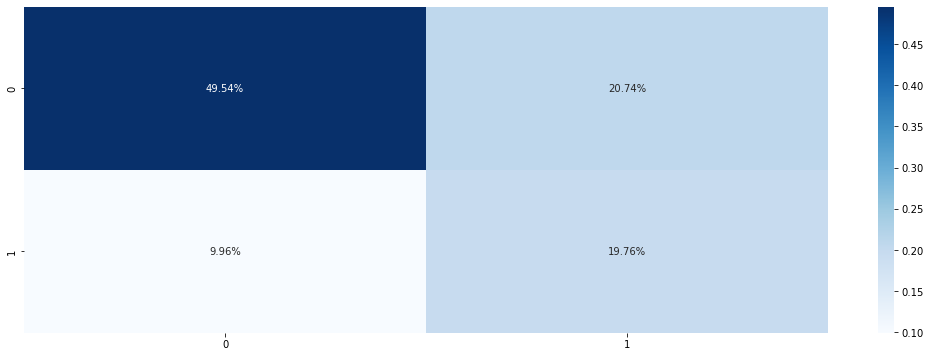

In [373]:
CustlogReg = CustomLogisticRegression(learning_rate = 0.15, iterations = 1000)
CustlogReg.fit(X_train, y_train)

prediction = CustlogReg.predict(X_test)
accuracy = accuracy_score(y_test, prediction)

# Getting and printing model scores
display(HTML("<h1>Custom Logistic Regression</h1>"))
print('----------------------------------------------------------------')
print("The Accuracy of the model is : ", accuracy*100, "%")
print('----------------------------------------------------------------')
# Look at classification report to evaluate the model
Confusion_Matrix_Graph(y_test, prediction)
print(classification_report(y_test,prediction))

----------------------------------------------------------------
Accuracy Training Score:  0.6846079421766288
Accuracy Test Score:  0.693028
The Accuracy of the model is :  69.30279999999999 %
----------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.83      0.70      0.76    351408
           1       0.49      0.66      0.56    148592

    accuracy                           0.69    500000
   macro avg       0.66      0.68      0.66    500000
weighted avg       0.73      0.69      0.70    500000



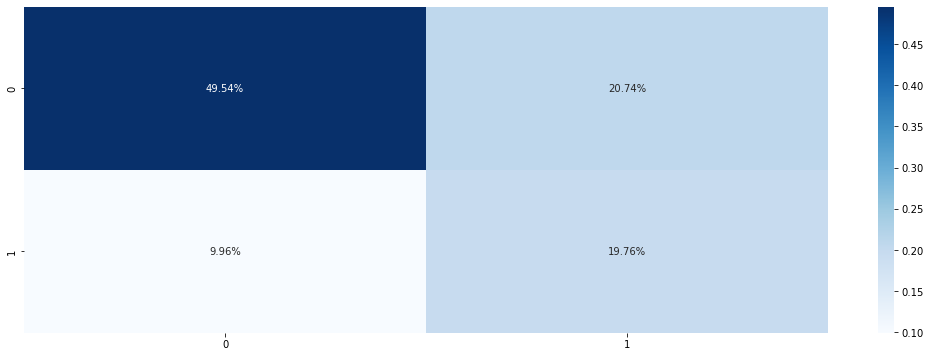

In [374]:
LogReg = LogisticRegression(solver='liblinear', max_iter=250)
LogReg.fit(X_train, y_train)

prediction = LogReg.predict(X_test)
accuracy = accuracy_score(y_test, prediction)
training_score = LogReg.score(X_train,y_train)
test_score = LogReg.score(X_test,y_test)

display(HTML("<h1>Logistic Regression</h1>"))
print('----------------------------------------------------------------')
print('Accuracy Training Score: ', training_score)
print('Accuracy Test Score: ', test_score)
print("The Accuracy of the model is : ", accuracy*100, "%")
print('----------------------------------------------------------------')
Confusion_Matrix_Graph(y_test, prediction)
print(classification_report(y_test,prediction))

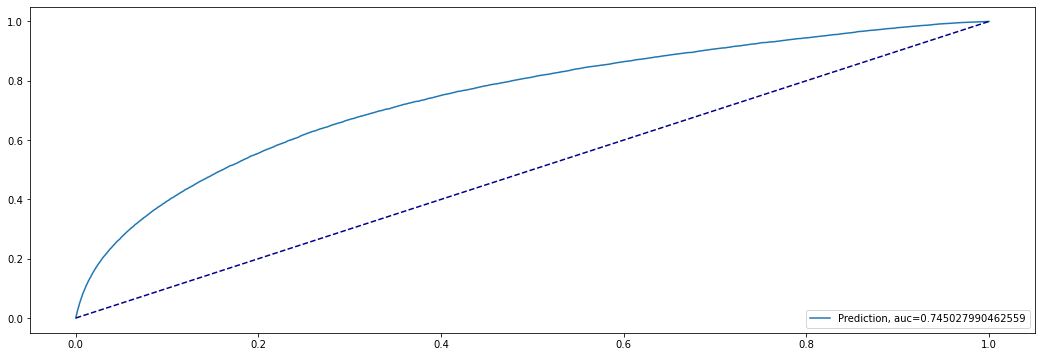

In [375]:
# The ROC Curve graph will also aid in analyzing the difference between the Positive predictions
# I will also calculate the Area Under the Curve value (AUC)

# For this I will be using the ROC_Curve_Graph function I created earlier 
# The only parameters I will need will be the X_test and y_test values

ROC_Curve_Graph(X_test,y_test,LogReg)

----------------------------------------------------------------
Accuracy Training Score:  0.7741544897059033
Accuracy Test Score:  0.743128
The Accuracy of the model is :  74.3128 %
----------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.84      0.79      0.81    351408
           1       0.56      0.64      0.60    148592

    accuracy                           0.74    500000
   macro avg       0.70      0.71      0.70    500000
weighted avg       0.76      0.74      0.75    500000



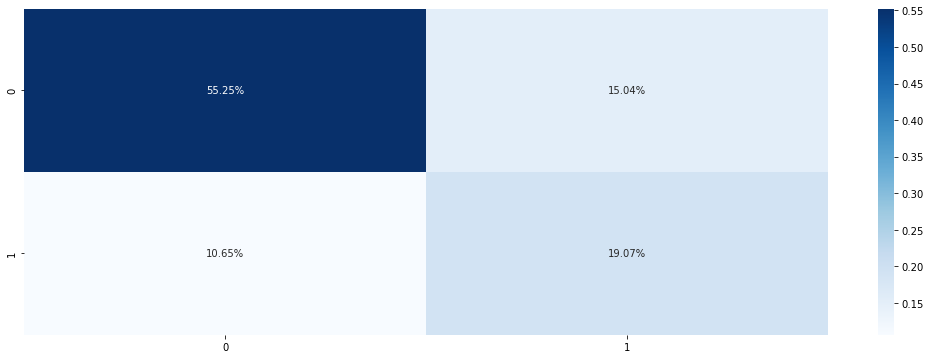

In [376]:
# creating a RF classifier
rfc = RandomForestClassifier(n_estimators = 50) 
rfc.fit(X_train, y_train)

prediction = rfc.predict(X_test)
accuracy = accuracy_score(y_test, prediction)
training_score = rfc.score(X_train,y_train)
test_score = rfc.score(X_test,y_test)

display(HTML("<h1>Random Forest Classifier</h1>"))
print('----------------------------------------------------------------')
print('Accuracy Training Score: ', training_score)
print('Accuracy Test Score: ', test_score)
print("The Accuracy of the model is : ", accuracy*100, "%")
print('----------------------------------------------------------------')
Confusion_Matrix_Graph(y_test, prediction)
print(classification_report(y_test,prediction))

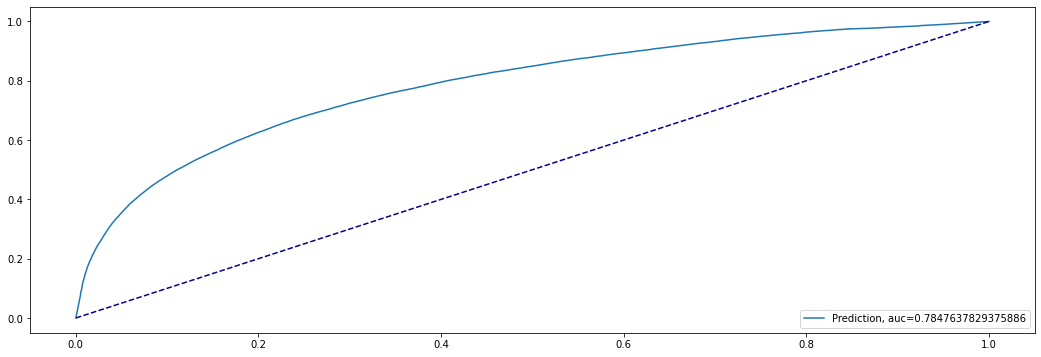

In [377]:
# The ROC Curve graph will also aid in analyzing the difference between the Positive predictions
# I will also calculate the Area Under the Curve value (AUC)

# For this I will be using the ROC_Curve_Graph function I created earlier 
# The only parameters I will need will be the X_test and y_test values

ROC_Curve_Graph(X_test,y_test,rfc)